In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
# from efficientnet_pytorch import EfficientNet
a = torch.Tensor([1]).cuda()
print(a)

tensor([1.], device='cuda:0')


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
plt.style.use('ggplot')
from PIL import Image, ImageDraw
from tqdm import tqdm

In [3]:
train_sample_metadata = pd.read_json('./input/train_sample_videos/metadata.json').T
train_sample_metadata.head()
train_sample_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, aagfhgtpmv.mp4 to eukvucdetx.mp4
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     400 non-null    object
 1   split     400 non-null    object
 2   original  323 non-null    object
dtypes: object(3)
memory usage: 28.7+ KB


In [4]:
input_dir = './output/deepfake-detection-challenge/train_sample_videos/'
real_dirs = []
fake_dirs = []
for i in range(len(train_sample_metadata)):
    fn = train_sample_metadata.index[i]
    label = train_sample_metadata.iloc[i,0]
    fn_dir = input_dir+fn+'/'
    if label=='REAL':
        real_dirs.append(fn_dir)
    else:
        fake_dirs.append(fn_dir)

In [5]:
class CustomDataset(Dataset):
    def __init__(self, real_dirs, fake_dirs, transform=None):
        self.image_list = []
        self.label_list = []
        self.transform = transform
        
        for directory in real_dirs:
            if not os.path.exists(directory):
                continue
            for filename in os.listdir(directory):
                if filename.endswith('.jpg'):
                    self.image_list.append(os.path.join(directory, filename))
                    self.label_list.append(0)
                    
        for directory in fake_dirs:
            if not os.path.exists(directory):
                continue
            for filename in os.listdir(directory):
                if filename.endswith('.jpg'):
                    self.image_list.append(os.path.join(directory, filename))
                    self.label_list.append(1)
        
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, index):
        image = Image.open(self.image_list[index]).convert('RGB')
        image = image.resize((224, 224))
        label = self.label_list[index]
        if self.transform:
            image = self.transform(image)
        return image, label

In [6]:
train_transforms = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(20),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
#     transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
train_data = CustomDataset(real_dirs, fake_dirs, transform=train_transforms)
# from sklearn.model_selection import train_test_split
# train_data, test_data = train_test_split(train_dataset, test_size=0.2)

In [8]:
test_sample_metadata = pd.read_json('./input/dfdc_train_part_0/metadata.json').T
test_sample_metadata.head()
test_sample_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1334 entries, owxbbpjpch.mp4 to etychryvty.mp4
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     1334 non-null   object
 1   split     1334 non-null   object
 2   original  1248 non-null   object
dtypes: object(3)
memory usage: 74.0+ KB


In [9]:
input_dir = './output/deepfake-detection-challenge/dfdc_train_part_0/'
real_dirs_t = []
fake_dirs_t = []
for i in range(len(test_sample_metadata)):
    fn = test_sample_metadata.index[i]
    label = test_sample_metadata.iloc[i,0]
    fn_dir = input_dir+fn+'/'
    if label=='REAL':
        real_dirs_t.append(fn_dir)
    else:
        fake_dirs_t.append(fn_dir)

In [10]:
test_data = CustomDataset(real_dirs_t, fake_dirs_t, transform=train_transforms)
# from sklearn.model_selection import train_test_split
# train_data, test_data = train_test_split(train_dataset, test_size=0.2)

In [11]:
BATCH_SIZE = 32
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
# train_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
# test_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
# model = EfficientNet.from_pretrained('efficientnet-b0')
# Using Swish
import torch
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        # Stem
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.swish1 = nn.SiLU()
        # Blocks
        self.blocks = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(64),
                nn.SiLU(),
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.SiLU(),
                nn.Conv2d(64, 32, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(32),
                nn.SiLU(),
            ),
            nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(64),
                nn.SiLU(),
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.SiLU(),
                nn.Conv2d(64, 32, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(32),
                nn.SiLU(),
            ),
        )
        # Head
        self.conv2 = nn.Conv2d(32, 128, kernel_size=1, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.swish2 = nn.SiLU()
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        # Stem
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.swish1(x)
        # Blocks
        x = self.blocks(x)
        # Head
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.swish2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = MyModel()

In [13]:
def display_model(model):
    # Check number of parameters 
    summary_dict = {}
    num_params = 0
    summary_str = ['='*80]

    for module_name, module in model.named_children():
        summary_count = 0
        for name, param in module.named_parameters():
            if(param.requires_grad):
                summary_count += param.numel()
                num_params += param.numel()
        summary_dict[module_name] = [summary_count]
        summary_str+= [f'- {module_name: <40} : {str(summary_count):^34s}']

    summary_dict['total'] = [num_params]

    # print summary string
    summary_str += ['='*80]
    summary_str += ['--' +  f'{"Total":<40} : {str(num_params) + " params":^34s}' +'--']
    print('\n'.join(summary_str))

    # print model structure
    print(model)

In [14]:
# model._fc = torch.nn.Linear(1280, 1)

In [15]:
# for param in model.parameters():
#     param.requires_grad = False
# for param in model._fc.parameters():
#     param.requires_grad = True

In [16]:
display_model(model)
# model.compile(loss="binary_crossentropy", optimizer="nadam",
#               metrics=["accuracy"])
# model.summary()

- conv1                                    :                864                
- bn1                                      :                 64                
- swish1                                   :                 0                 
- blocks                                   :               82560               
- conv2                                    :                4096               
- bn2                                      :                256                
- swish2                                   :                 0                 
- pool                                     :                 0                 
- fc                                       :                129                
--Total                                    :            87969 params           --
MyModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (swish1): 

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def train(train_loader, model, criterion, optimizer):
    """
    Train network
    :param train_loader: training dataloader
    :param model: model to be trained
    :param criterion: criterion used to calculate loss (should be CrossEntropyLoss from torch.nn)
    :param optimizer: optimizer for model's params (Adams or SGD)
    :return: mean training loss
    """
    model.train()
    loss_ = 0.0
    losses = []
    # TO DO: read this documentation and then uncomment the line below; https://pypi.org/project/tqdm/
    it_train = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training ...", position = 0) # progress bar
    for i, (images, labels) in it_train:
        # TO DO: read/understand and then uncomment these lines
        images, labels = images.to(device), labels.view(-1, 1).to(device).float()
        optimizer.zero_grad()
        prediction = model(images)
        loss = criterion(prediction, labels)
        it_train.set_description(f'loss: {loss:.3f}')
        loss.backward()
        optimizer.step()
        losses.append(loss)

    return torch.stack(losses).mean().item()

def test(test_loader, model, criterion):
    """
    Test network.
    :param test_loader: testing dataloader
    :param model: model to be tested
    :param criterion: criterion used to calculate loss (should be CrossEntropyLoss from torch.nn)
    :return: mean_accuracy: mean accuracy of predicted labels
             test_loss: mean test loss during testing
             precision: precision score of predicted labels
             recall: recall score of predicted labels
             f1: f1 score of predicted labels
    """
    model.eval()
    losses = []
    correct = 0
    total = 0
    predicted_labels = []
    true_labels = []
    it_test = tqdm(enumerate(test_loader), total=len(test_loader), desc="Validating ...", position = 0)
    for i, (images, labels) in it_test:
        images, labels = images.to(device), labels.view(-1, 1).to(device).float()
        with torch.no_grad():
            output = model(images)
            preds = torch.round(torch.sigmoid(output)).type(torch.int)
            loss = criterion(output, labels)
            losses.append(loss.item())
            predicted_labels.extend(preds.cpu().detach().numpy())
            true_labels.extend(labels.cpu().detach().numpy())
            correct += (preds == labels).sum().item()
            total += len(labels)
    mean_accuracy = correct / total
    test_loss = np.mean(losses)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    print('Mean Accuracy: {0:.4f}'.format(mean_accuracy))
    print('Avg loss: {}'.format(test_loss))
    print('Precision: {0:.4f}'.format(precision))
    print('Recall: {0:.4f}'.format(recall))
    print('F1 Score: {0:.4f}'.format(f1))

    return mean_accuracy, test_loss, precision, recall, f1

In [18]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

cuda


In [19]:
train_losses = []
train_accuracy_list = []
test_losses = []
test_accuracy_list = []
test_precision_list = []
test_recall_list = []
test_f1_list = []
test_interval = 5

# Iterate over the DataLoader for training data
for epoch in tqdm(range(num_epochs), total=num_epochs, desc="Training ...", position=1):
    train_loss = train(train_loader, model, criterion, optimizer) # Train the Network for one epoch
    # TO DO: uncomment the line below. It should be called each epoch to apply the lr_scheduler
    scheduler.step()
    train_losses.append(train_loss)
    print(f'Loss for Training on epoch {str(epoch)} is {str(train_loss)} \n')

    if(epoch%test_interval==0 or epoch==1 or epoch==num_epochs-1):
        print('Evaluating Network')

        train_accuracy, _, _, _, _ = test(train_loader, model, criterion)
        train_accuracy_list.append(train_accuracy)

        print(f'Training accuracy on epoch {str(epoch)} is {str(train_accuracy)} \n')

        test_accuracy, test_loss, test_precision, test_recall, test_f1 = test(test_loader, model, criterion)
        test_losses.append(test_loss)
        test_accuracy_list.append(test_accuracy)
        test_precision_list.append(test_precision)
        test_recall_list.append(test_recall)
        test_f1_list.append(test_f1)

        print(f'Testing accuracy on epoch {str(epoch)} is {str(test_accuracy)} \n')


loss: 0.543: 100%|██████████| 336/336 [00:31<00:00, 10.78it/s]


Loss for Training on epoch 0 is 0.4734174609184265 

Evaluating Network


Validating ...: 100%|██████████| 336/336 [00:34<00:00,  9.75it/s]


Mean Accuracy: 0.8016
Avg loss: 0.47594062740071896
Precision: 0.8034
Recall: 0.9945
F1 Score: 0.8888
Training accuracy on epoch 0 is 0.8016028329139875 



Validating ...: 100%|██████████| 785/785 [01:23<00:00,  9.41it/s]

Training ...:   5%|▌         | 1/20 [02:29<47:18, 149.41s/it]

Mean Accuracy: 0.8489
Avg loss: 0.45172497949972273
Precision: 0.8492
Recall: 0.9994
F1 Score: 0.9182
Testing accuracy on epoch 0 is 0.8489251592356688 



loss: 0.392: 100%|██████████| 336/336 [00:31<00:00, 10.77it/s]


Loss for Training on epoch 1 is 0.4563524127006531 

Evaluating Network


Validating ...: 100%|██████████| 336/336 [00:34<00:00,  9.69it/s]


Mean Accuracy: 0.8028
Avg loss: 0.454524791755137
Precision: 0.8106
Recall: 0.9822
F1 Score: 0.8882
Training accuracy on epoch 1 is 0.8028142763954897 



Validating ...: 100%|██████████| 785/785 [01:26<00:00,  9.11it/s]

Training ...:  10%|█         | 2/20 [05:01<45:21, 151.20s/it]

Mean Accuracy: 0.8503
Avg loss: 0.43139177839847126
Precision: 0.8557
Recall: 0.9906
F1 Score: 0.9182
Testing accuracy on epoch 1 is 0.8503184713375797 



loss: 0.430: 100%|██████████| 336/336 [00:32<00:00, 10.28it/s]

Training ...:  15%|█▌        | 3/20 [05:34<27:30, 97.10s/it] 

Loss for Training on epoch 2 is 0.4535338580608368 



loss: 0.212: 100%|██████████| 336/336 [00:32<00:00, 10.28it/s]

Training ...:  20%|██        | 4/20 [06:07<19:06, 71.68s/it]

Loss for Training on epoch 3 is 0.45088472962379456 



loss: 0.206: 100%|██████████| 336/336 [00:37<00:00,  8.95it/s]

Training ...:  25%|██▌       | 5/20 [06:44<14:50, 59.38s/it]

Loss for Training on epoch 4 is 0.44890499114990234 



loss: 0.494: 100%|██████████| 336/336 [00:38<00:00,  8.82it/s]


Loss for Training on epoch 5 is 0.4409799575805664 

Evaluating Network


Validating ...: 100%|██████████| 336/336 [00:37<00:00,  8.95it/s]


Mean Accuracy: 0.8104
Avg loss: 0.4259138147657116
Precision: 0.8195
Recall: 0.9774
F1 Score: 0.8915
Training accuracy on epoch 5 is 0.8103625011648495 



Validating ...: 100%|██████████| 785/785 [01:43<00:00,  7.58it/s]

Training ...:  30%|███       | 6/20 [09:44<23:23, 100.27s/it]

Mean Accuracy: 0.7518
Avg loss: 0.8909159695421149
Precision: 0.8600
Recall: 0.8450
F1 Score: 0.8524
Testing accuracy on epoch 5 is 0.7518312101910828 



loss: 0.426: 100%|██████████| 336/336 [00:37<00:00,  8.96it/s]

Training ...:  35%|███▌      | 7/20 [10:22<17:16, 79.76s/it] 

Loss for Training on epoch 6 is 0.43580588698387146 



loss: 0.204: 100%|██████████| 336/336 [00:37<00:00,  9.07it/s]

Training ...:  40%|████      | 8/20 [10:59<13:14, 66.17s/it]

Loss for Training on epoch 7 is 0.43160417675971985 



loss: 0.627: 100%|██████████| 336/336 [00:36<00:00,  9.30it/s]

Training ...:  45%|████▌     | 9/20 [11:35<10:24, 56.79s/it]

Loss for Training on epoch 8 is 0.4293142259120941 



loss: 0.559: 100%|██████████| 336/336 [00:35<00:00,  9.41it/s]

Training ...:  50%|█████     | 10/20 [12:11<08:22, 50.29s/it]

Loss for Training on epoch 9 is 0.4321480393409729 



loss: 0.205: 100%|██████████| 336/336 [00:43<00:00,  7.80it/s]


Loss for Training on epoch 10 is 0.42667481303215027 

Evaluating Network


Validating ...: 100%|██████████| 336/336 [00:44<00:00,  7.58it/s]


Mean Accuracy: 0.8153
Avg loss: 0.4172316576309857
Precision: 0.8256
Recall: 0.9742
F1 Score: 0.8937
Training accuracy on epoch 10 is 0.8153014630509738 



Validating ...: 100%|██████████| 785/785 [01:43<00:00,  7.60it/s]

Training ...:  55%|█████▌    | 11/20 [15:22<14:01, 93.45s/it]

Mean Accuracy: 0.6338
Avg loss: 1.5082620623201688
Precision: 0.8528
Recall: 0.6869
F1 Score: 0.7609
Testing accuracy on epoch 10 is 0.6338375796178344 



loss: 0.615: 100%|██████████| 336/336 [00:39<00:00,  8.57it/s]

Training ...:  60%|██████    | 12/20 [16:01<10:15, 76.95s/it]

Loss for Training on epoch 11 is 0.42572686076164246 



loss: 0.592: 100%|██████████| 336/336 [00:39<00:00,  8.51it/s]

Training ...:  65%|██████▌   | 13/20 [16:41<07:39, 65.61s/it]

Loss for Training on epoch 12 is 0.42544829845428467 



loss: 0.279: 100%|██████████| 336/336 [00:41<00:00,  8.16it/s]

Training ...:  70%|███████   | 14/20 [17:22<05:49, 58.24s/it]

Loss for Training on epoch 13 is 0.4274853467941284 



loss: 0.754: 100%|██████████| 336/336 [00:36<00:00,  9.25it/s]

Training ...:  75%|███████▌  | 15/20 [17:58<04:18, 51.64s/it]

Loss for Training on epoch 14 is 0.42709606885910034 



loss: 0.784: 100%|██████████| 336/336 [00:34<00:00,  9.67it/s]


Loss for Training on epoch 15 is 0.4270499646663666 

Evaluating Network


Validating ...: 100%|██████████| 336/336 [00:38<00:00,  8.73it/s]


Mean Accuracy: 0.8137
Avg loss: 0.415445981902026
Precision: 0.8240
Recall: 0.9745
F1 Score: 0.8930
Training accuracy on epoch 15 is 0.8137172677290094 



Validating ...: 100%|██████████| 785/785 [01:32<00:00,  8.52it/s]

Training ...:  80%|████████  | 16/20 [20:44<05:43, 85.99s/it]

Mean Accuracy: 0.6752
Avg loss: 1.4963399012699372
Precision: 0.8573
Recall: 0.7403
F1 Score: 0.7945
Testing accuracy on epoch 15 is 0.6751990445859872 



loss: 0.541: 100%|██████████| 336/336 [00:34<00:00,  9.65it/s]

Training ...:  85%|████████▌ | 17/20 [21:19<03:31, 70.61s/it]

Loss for Training on epoch 16 is 0.4260583817958832 



loss: 0.561: 100%|██████████| 336/336 [00:35<00:00,  9.34it/s]

Training ...:  90%|█████████ | 18/20 [21:55<02:00, 60.21s/it]

Loss for Training on epoch 17 is 0.42540037631988525 



loss: 0.446: 100%|██████████| 336/336 [00:36<00:00,  9.14it/s]

Training ...:  95%|█████████▌| 19/20 [22:31<00:53, 53.17s/it]

Loss for Training on epoch 18 is 0.42862483859062195 



loss: 0.688: 100%|██████████| 336/336 [00:39<00:00,  8.54it/s]


Loss for Training on epoch 19 is 0.42535659670829773 

Evaluating Network


Validating ...: 100%|██████████| 336/336 [00:41<00:00,  8.09it/s]


Mean Accuracy: 0.8136
Avg loss: 0.4154513398894951
Precision: 0.8229
Recall: 0.9764
F1 Score: 0.8931
Training accuracy on epoch 19 is 0.8136240797688938 



Validating ...: 100%|██████████| 785/785 [01:40<00:00,  7.80it/s]

Training ...: 100%|██████████| 20/20 [25:33<00:00, 76.70s/it]

Mean Accuracy: 0.6495
Avg loss: 1.5455866838796724
Precision: 0.8541
Recall: 0.7077
F1 Score: 0.7741
Testing accuracy on epoch 19 is 0.6495222929936306 



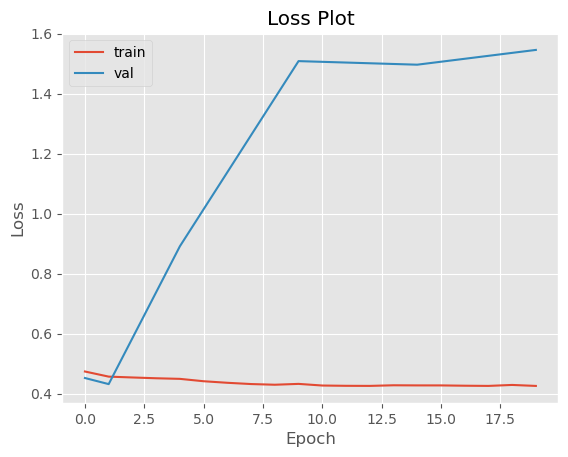

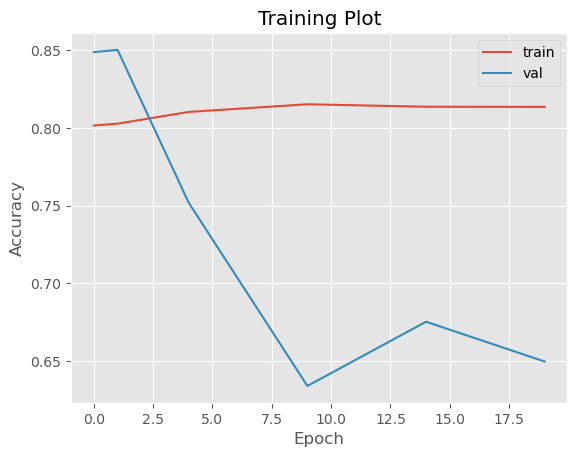

In [20]:
def plot_losses(train, val, test_frequency, num_epochs):
    plt.plot(train, label="train")
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0 or i == 1)]
    plt.plot(indices, val, label="val")
    plt.title("Loss Plot")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()
    
def plot_accuracy(train, val, test_frequency, num_epochs):
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0 or i == 1)]
    plt.plot(indices, train, label="train")
    plt.plot(indices, val, label="val")
    plt.title("Training Plot")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()
plot_losses(train_losses, test_losses, test_interval, num_epochs)
plot_accuracy(train_accuracy_list, test_accuracy_list, test_interval, num_epochs)

In [21]:
import random
def eval_example(model, dirs):
    model.eval()
    image_path = random.choice(dirs)+'0.jpg'
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)
    plt.show()
    image = image.resize((224, 224))
    image = train_transforms(image).unsqueeze(0).to(device)
    output = model(image)
    pred = torch.sigmoid(output).item()
    print(output.item())
    if pred>0.5:
        print('Prediction: FAKE')
    else:
        print('Prediction: REAL')

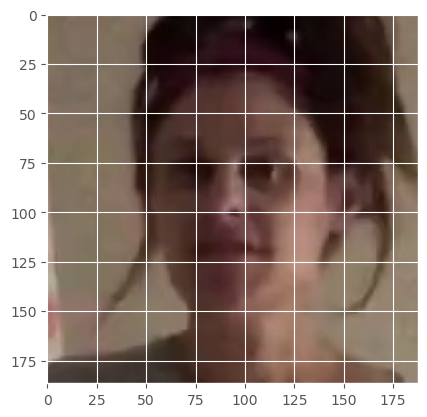

1.5640236139297485
Prediction: FAKE


In [23]:
f = eval_example(model, fake_dirs_t)

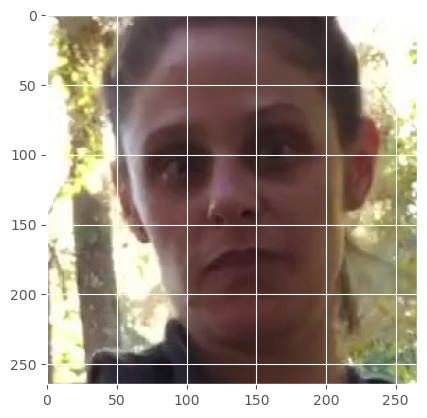

-0.049475230276584625
Prediction: REAL


In [25]:
r = eval_example(model, real_dirs_t)

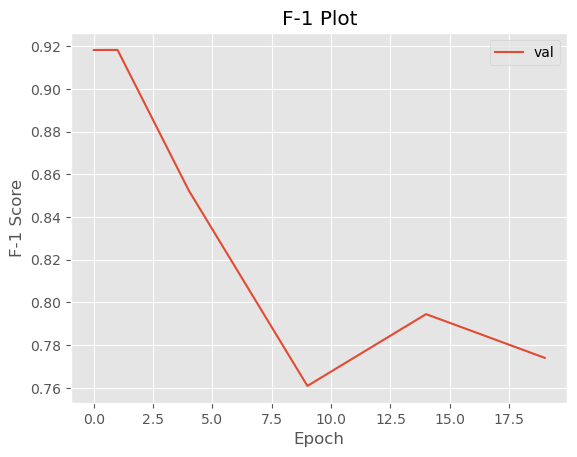

In [26]:
def plot_F1(val, test_frequency, num_epochs):
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0 or i == 1)]
    plt.plot(indices, val, label="val")
    plt.title("F-1 Plot")
    plt.ylabel("F-1 Score")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()
plot_F1(test_f1_list, test_interval, num_epochs)